In [1]:
# Initial setup and imports
import os
import gc
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Enable GPU memory growth to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU memory growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"GPU setup error: {e}")
else:
    print("No GPUs found, using CPU")

print(f"TensorFlow version: {tf.__version__}")


No GPUs found, using CPU
TensorFlow version: 2.19.0


In [2]:
# Configuration - reduced sizes to prevent memory issues
IMG_SIZE = 256  # Reduced from 512 to prevent memory issues
BATCH_SIZE = 4  # Small batch size for memory efficiency
NUM_CLASSES = 4  # 0=Soil, 1=Sand, 2=Bedrock, 3=Big Rock
BUFFER_SIZE = 1000
EPOCHS = 5  # Start with fewer epochs for testing

# Dataset paths
TRAIN_IMG_DIR = "dataset/train/images"
TRAIN_MASK_DIR = "dataset/train/masks"
TEST_IMG_DIR = "dataset/test/images"
TEST_MASK_DIR = "dataset/test/masks"

# Verify dataset existence and count files
for dir_path in [TRAIN_IMG_DIR, TRAIN_MASK_DIR, TEST_IMG_DIR, TEST_MASK_DIR]:
    if os.path.exists(dir_path):
        count = len([f for f in os.listdir(dir_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(f"{dir_path}: {count} files")
    else:
        print(f"ERROR: {dir_path} does not exist!")

# Define color map for visualization
colormap = {
    0: (139, 69, 19),    # Brown (Soil)
    1: (255, 255, 0),    # Yellow (Sand)
    2: (128, 128, 128),  # Gray (Bedrock)
    3: (255, 0, 0),      # Red (Big Rock)
}


dataset/train/images: 12851 files
dataset/train/masks: 12851 files
dataset/test/images: 3213 files
dataset/test/masks: 3213 files


In [3]:
# CRITICAL FIX: Preprocessing function that handles mask values of 255
def preprocess_image(image_path, mask_path):
    """Memory-efficient preprocessing function using TensorFlow ops"""
    # Read image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    
    # Read mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.cast(mask, tf.int32)
    mask = tf.squeeze(mask, axis=-1)  # Remove channel dimension
    
    # CRITICAL: Remap 255 values to 0 (valid class index)
    # This fixes the "label value of 255 outside valid range [0, 4)" error
    mask = tf.where(mask == 255, 0, mask)
    
    # Resize
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    mask = tf.image.resize(mask[..., tf.newaxis], [IMG_SIZE, IMG_SIZE], method='nearest')
    mask = tf.squeeze(mask, axis=-1)
    
    return image, mask

def create_dataset(image_dir, mask_dir, is_training=True):
    """Create tf.data.Dataset with efficient preprocessing"""
    # Get file paths
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg'))]
    mask_files = [f.replace('.JPG', '.png').replace('.jpg', '.png') for f in image_files]
    
    image_paths = [os.path.join(image_dir, f) for f in image_files]
    mask_paths = [os.path.join(mask_dir, f) for f in mask_files]
    
    # Verify files exist
    valid_pairs = []
    for img_path, mask_path in zip(image_paths, mask_paths):
        if os.path.exists(img_path) and os.path.exists(mask_path):
            valid_pairs.append((img_path, mask_path))
    
    print(f"Found {len(valid_pairs)} valid image-mask pairs in {image_dir}")
    
    image_paths, mask_paths = zip(*valid_pairs)
    
    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((list(image_paths), list(mask_paths)))
    dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_training:
        dataset = dataset.shuffle(BUFFER_SIZE)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset


In [4]:
# Create datasets and test data loading
print("Creating training dataset...")
train_dataset = create_dataset(TRAIN_IMG_DIR, TRAIN_MASK_DIR, is_training=True)

print("Creating test dataset...")
test_dataset = create_dataset(TEST_IMG_DIR, TEST_MASK_DIR, is_training=False)

# Calculate dataset sizes
train_size = len([f for f in os.listdir(TRAIN_IMG_DIR) if f.lower().endswith(('.jpg', '.jpeg'))])
test_size = len([f for f in os.listdir(TEST_IMG_DIR) if f.lower().endswith(('.jpg', '.jpeg'))])

steps_per_epoch = train_size // BATCH_SIZE
validation_steps = test_size // BATCH_SIZE

print(f"Training samples: {train_size}, Steps per epoch: {steps_per_epoch}")
print(f"Test samples: {test_size}, Validation steps: {validation_steps}")

# Test data loading and verify mask values are now in valid range
print("\nTesting data loading...")
for batch_images, batch_masks in train_dataset.take(1):
    print(f"Batch shape - Images: {batch_images.shape}, Masks: {batch_masks.shape}")
    print(f"Image dtype: {batch_images.dtype}, range: [{tf.reduce_min(batch_images):.3f}, {tf.reduce_max(batch_images):.3f}]")
    print(f"Mask dtype: {batch_masks.dtype}, range: [{tf.reduce_min(batch_masks)}, {tf.reduce_max(batch_masks)}]")
    
    # Check unique mask values to ensure 255 is remapped
    unique_values = tf.unique(tf.reshape(batch_masks, [-1]))[0]
    print(f"Unique mask values in batch: {unique_values.numpy()}")
    
    if tf.reduce_max(batch_masks) >= NUM_CLASSES:
        print("ERROR: Mask values still outside valid range!")
    else:
        print("✓ All mask values are now in valid range [0, 3]")

# Clean up memory
gc.collect()
print("\nData loading test completed successfully!")


Creating training dataset...
Found 12851 valid image-mask pairs in dataset/train/images
Creating test dataset...
Found 3213 valid image-mask pairs in dataset/test/images
Training samples: 12851, Steps per epoch: 3212
Test samples: 3213, Validation steps: 803

Testing data loading...
Batch shape - Images: (4, 256, 256, 3), Masks: (4, 256, 256)
Image dtype: <dtype: 'float32'>, range: [0.003, 0.876]
Mask dtype: <dtype: 'int32'>, range: [0, 3]
Unique mask values in batch: [0 1 2 3]
✓ All mask values are now in valid range [0, 3]

Data loading test completed successfully!


2025-08-05 23:55:54.266091: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def atrous_spatial_pyramid_pooling(x, filters):
    dims = x.shape

    pool = layers.AveragePooling2D(pool_size=(dims[1], dims[2]))(x)
    pool = layers.Conv2D(filters, 1, padding="same", use_bias=False)(pool)
    pool = layers.BatchNormalization()(pool)
    pool = layers.Activation("relu")(pool)
    pool = layers.UpSampling2D(size=(dims[1], dims[2]), interpolation="bilinear")(pool)

    conv_1x1 = layers.Conv2D(filters, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    conv_1x1 = layers.BatchNormalization()(conv_1x1)
    conv_1x1 = layers.Activation("relu")(conv_1x1)

    conv_3x3_r6 = layers.Conv2D(filters, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    conv_3x3_r6 = layers.BatchNormalization()(conv_3x3_r6)
    conv_3x3_r6 = layers.Activation("relu")(conv_3x3_r6)

    conv_3x3_r12 = layers.Conv2D(filters, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    conv_3x3_r12 = layers.BatchNormalization()(conv_3x3_r12)
    conv_3x3_r12 = layers.Activation("relu")(conv_3x3_r12)

    conv_3x3_r18 = layers.Conv2D(filters, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    conv_3x3_r18 = layers.BatchNormalization()(conv_3x3_r18)
    conv_3x3_r18 = layers.Activation("relu")(conv_3x3_r18)

    concat = layers.Concatenate()([pool, conv_1x1, conv_3x3_r6, conv_3x3_r12, conv_3x3_r18])

    output = layers.Conv2D(filters, 1, padding="same", use_bias=False)(concat)
    output = layers.BatchNormalization()(output)
    output = layers.Activation("relu")(output)

    return output

def deeplabv3plus(input_shape=(256, 256, 3), num_classes=4):
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    image_input = base_model.input
    x = base_model.get_layer("block_13_expand_relu").output  # high-level features
    low_level_feat = base_model.get_layer("block_3_expand_relu").output  # low-level features

    x = atrous_spatial_pyramid_pooling(x, 256)
    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)

    low_level_feat = layers.Conv2D(48, 1, padding="same", use_bias=False)(low_level_feat)
    low_level_feat = layers.BatchNormalization()(low_level_feat)
    low_level_feat = layers.Activation("relu")(low_level_feat)

    x = layers.Concatenate()([x, low_level_feat])

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.UpSampling2D(size=(4, 4), interpolation="bilinear")(x)
    outputs = layers.Conv2D(num_classes, 1, padding="same", activation="softmax")(x)

    return Model(inputs=image_input, outputs=outputs)


In [6]:
model= deeplabv3plus(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=4)
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/var/folders/wc/3m1jp8cj4f7fy8sfc6278n_c0000gn/T/ipykernel_2173/3064615532.py:38: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')


In [7]:
# Start training with error handling
print("Starting training...")
print("=" * 50)

try:
    history = model.fit(
        train_dataset,
        epochs=10,
        steps_per_epoch=steps_per_epoch,
        validation_data=test_dataset,
        validation_steps=validation_steps,
        verbose=1
    )
    
    print("\n🎉 Training completed successfully!")
    
except Exception as e:
    print(f"\n❌ Training failed with error: {e}")
    print("\nTroubleshooting suggestions:")
    print("1. Reduce BATCH_SIZE further (try 2 or 1)")
    print("2. Reduce IMG_SIZE further (try 128)")
    print("3. Check GPU memory: nvidia-smi")
    print("4. Restart kernel to clear memory")
    raise e


Starting training...
Epoch 1/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 40217s 13s/step - accuracy: 0.8152 - loss: 0.4752 - val_accuracy: 0.7591 - val_loss: 0.5542
Epoch 2/10
   1/3212 ━━━━━━━━━━━━━━━━━━━━ 32:52 614ms/step - accuracy: 0.8895 - loss: 0.3194

/Users/yatharthvardan/Documents/USD/ai4mars-dataset-merged-0.1/py11/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3212/3212 ━━━━━━━━━━━━━━━━━━━━ 100s 31ms/step - accuracy: 0.8895 - loss: 0.3194 - val_accuracy: 0.7566 - val_loss: 0.5598
Epoch 3/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 2934s 913ms/step - accuracy: 0.8751 - loss: 0.3134 - val_accuracy: 0.8446 - val_loss: 0.3843
Epoch 4/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 117s 36ms/step - accuracy: 0.8103 - loss: 0.4492 - val_accuracy: 0.8466 - val_loss: 0.3788
Epoch 5/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 3191s 993ms/step - accuracy: 0.8874 - loss: 0.2839 - val_accuracy: 0.8598 - val_loss: 0.3615
Epoch 6/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 123s 38ms/step - accuracy: 0.9721 - loss: 0.0988 - val_accuracy: 0.8606 - val_loss: 0.3581
Epoch 7/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 2844s 885ms/step - accuracy: 0.8972 - loss: 0.2550 - val_accuracy: 0.8817 - val_loss: 0.2926
Epoch 8/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 113s 35ms/step - accuracy: 0.9081 - loss: 0.2263 - val_accuracy: 0.8837 - val_loss: 0.2877
Epoch 9/10
3212/3212 ━━━━━━━━━━━━━━━━━━━━ 4103s 1s/step - accuracy: 0.9010

In [8]:
model.save("deeplabv3_mars_model.keras")

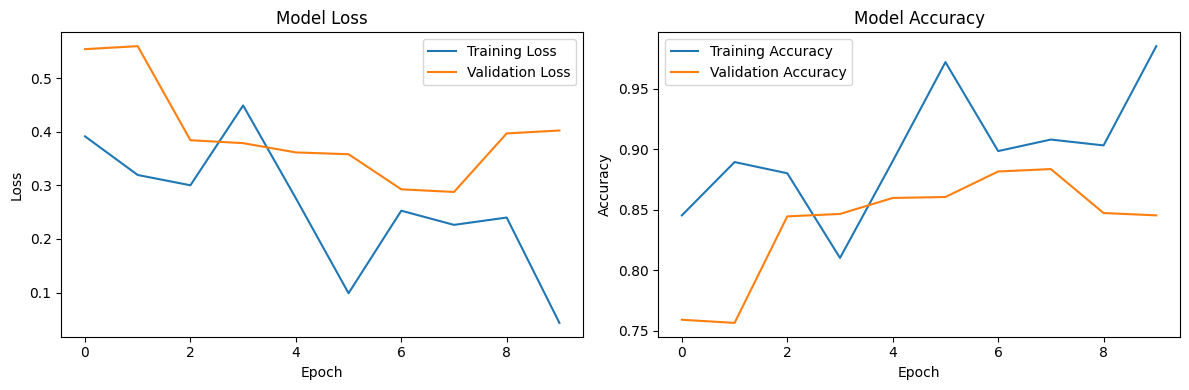

Sample predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


2025-08-06 16:43:43.715147: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


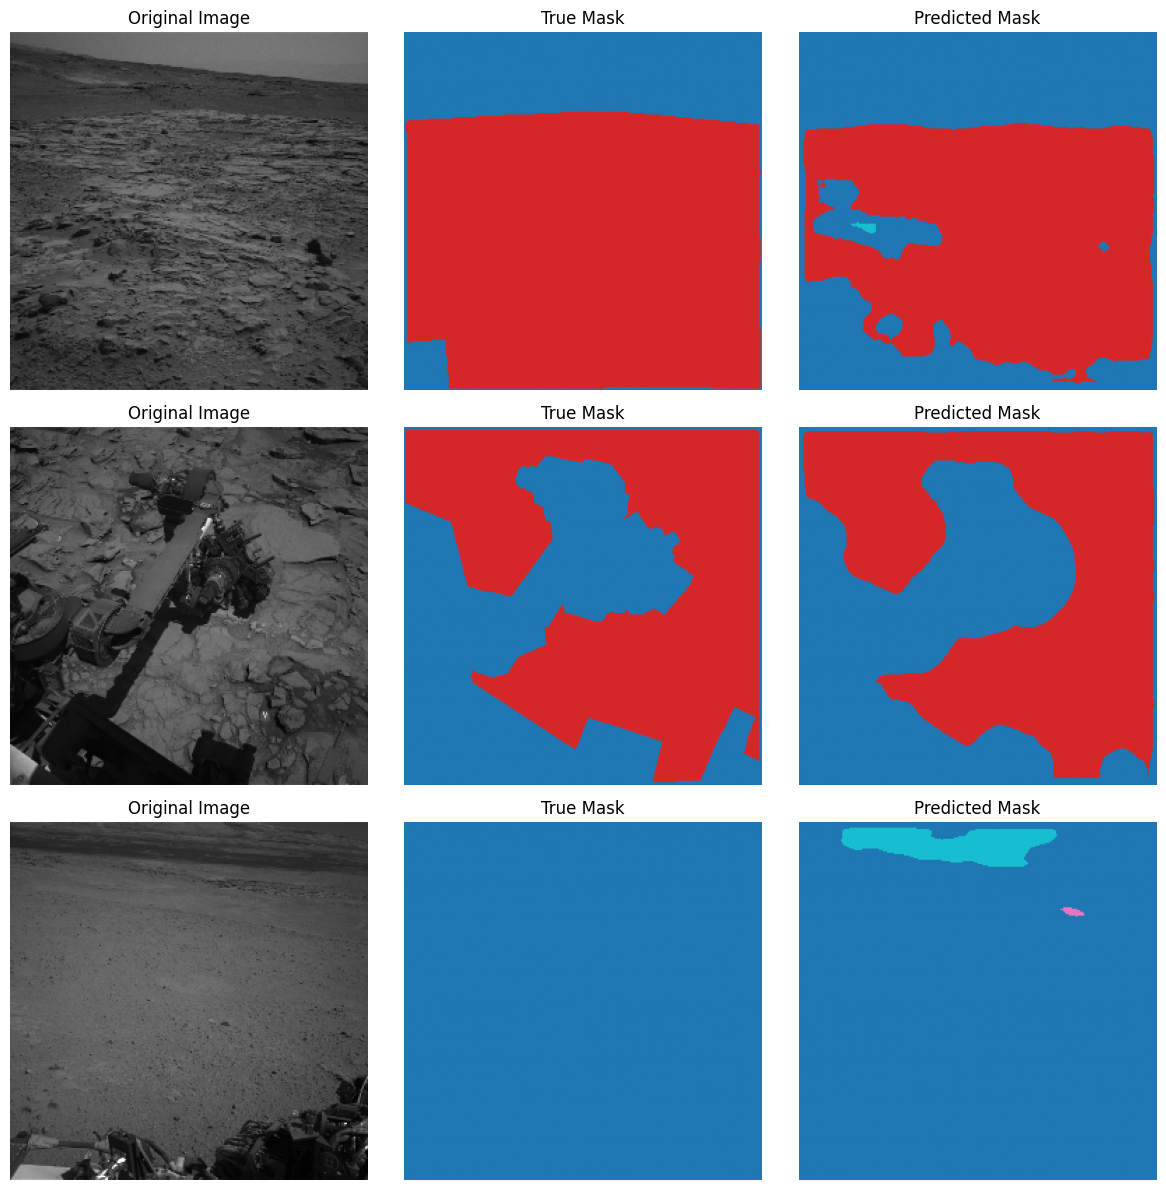

In [9]:
# Visualization and results
def visualize_sample_predictions(model, dataset, num_samples=3):
    """Visualize sample predictions"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    for i, (images, masks) in enumerate(dataset.take(num_samples)):
        # Take first image from batch
        image = images[0]
        true_mask = masks[0]
        
        # Predict
        pred_mask = model.predict(tf.expand_dims(image, 0))[0]
        pred_mask = tf.argmax(pred_mask, axis=-1)
        
        # Plot
        axes[i, 0].imshow(image)
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(true_mask, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 1].set_title('True Mask')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(pred_mask, cmap='tab10', vmin=0, vmax=NUM_CLASSES-1)
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot training history if training succeeded
if 'history' in locals():
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Show sample predictions
    print("Sample predictions:")
    visualize_sample_predictions(model, test_dataset)



In [10]:
print(f"Accuracy of the DeepLabv3 Image segmentation model is {history.history['accuracy'][-1]}")
print(f"Loss of the DeepLabv3 Image segmentation model is {history.history['loss'][-1]}")
print(f"Validation Accuracy of the DeepLabv3 Image segmentation model is {history.history['val_accuracy'][-1]}")
print(f"Validation Loss of the DeepLabv3 Image segmentation model is {history.history['val_loss'][-1]}")
print(f"Epochs of the DeepLabv3 Image segmentation model is {history.epoch[-1]}")

Accuracy of the DeepLabv3 Image segmentation model is 0.9852498173713684
Loss of the DeepLabv3 Image segmentation model is 0.043418120592832565
Validation Accuracy of the DeepLabv3 Image segmentation model is 0.845430314540863
Validation Loss of the DeepLabv3 Image segmentation model is 0.4023802578449249
Epochs of the DeepLabv3 Image segmentation model is 9


In [11]:
import numpy as np

def compute_class_iou(y_true, y_pred, num_classes):
    iou_per_class = {}
    
    for class_id in range(2):
        # Create binary masks for current class
        true_class = (y_true == class_id)
        pred_class = (y_pred == class_id)
        
        intersection = np.logical_and(true_class, pred_class).sum()
        union = np.logical_or(true_class, pred_class).sum()
        
        iou = intersection / union if union != 0 else 0.0
        iou_per_class[f"class_{class_id}"] = round(iou, 4)
    
    mean_iou = round(np.mean(list(iou_per_class.values())), 4)
    return iou_per_class, mean_iou


In [12]:
# Assuming your model outputs softmax over classes:
MEAN_IOU = []

for i, (image, mask) in enumerate(test_dataset):
    image = image[0]
    true_mask = mask[0]
        
    # Predict
    pred_mask = model.predict(tf.expand_dims(image, 0))[0]
    pred_mask = tf.argmax(pred_mask, axis=-1)        # shape: (H, W)
    
    true_class_mask = true_mask.numpy().squeeze()              # shape: (H, W), same format
    num_classes = pred_mask.shape[-1]
    per_class_iou, mean_iou = compute_class_iou(true_class_mask, pred_mask, num_classes)
    MEAN_IOU.append(mean_iou)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

In [13]:
print(f"Mean IOU of the model is {np.mean(MEAN_IOU)}")

Mean IOU of the model is 0.5618355721393036


In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, jaccard_score

def evaluate_segmentation(model, data_loader, num_classes=2):
    y_true_all = []
    y_pred_all = []

    for images, masks in data_loader:
        preds = model.predict(images)
        preds = np.argmax(preds, axis=-1).flatten()
        true = masks.numpy().flatten()

        y_true_all.extend(true)
        y_pred_all.extend(preds)

    y_true_all = np.array(y_true_all)
    y_pred_all = np.array(y_pred_all)

    f1 = f1_score(y_true_all, y_pred_all, average='macro')
    precision = precision_score(y_true_all, y_pred_all, average='macro')
    recall = recall_score(y_true_all, y_pred_all, average='macro')
    iou = jaccard_score(y_true_all, y_pred_all, average='macro')

    print(f"F1 Score (Macro):     {f1:.4f}")
    print(f"Precision (Macro):   {precision:.4f}")
    print(f"Recall (Macro):      {recall:.4f}")
    print(f"IoU (Jaccard Index): {iou:.4f}")


In [17]:
evaluate_segmentation(model, test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 